<a href="https://colab.research.google.com/github/vibha-ctrl/KVCachingFromScratch/blob/main/KVCachingFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding KV Caching in Transformers

Modern large language models (LLMs) like GPT-2, LLaMA, and GPT-4 generate text one token at a time during inference. At each decoding step, the model uses *self-attention* so the new token can "look back" at all previous tokens.

Naively, this would mean recomputing **Key (K)** and **Value (V)** vectors for **all past tokens** at every step — which quickly becomes very slow and expensive as the sequence grows.

**KV caching** is the key optimization that makes autoregressive decoding fast:

- For each token, the model computes **K** and **V** once.
- These K and V tensors are stored in a cache
- When generating new tokens, the model:
  - Computes **Q (Query)** for the new token
  - Reuses cached **K/V** from all previous tokens
  - Only computes K/V for the new token

This notebook walks through:

1. Loading a small GPT-2 model in PyTorch
2. Implementing **naive decoding** (no KV cache, recompute everything)
3. Implementing **KV-cached decoding** (reuse past K/V)
4. Benchmarking and comparing their speeds

By the end, you’ll *see* how KV caching works in practice and why it’s critical for fast LLM inference.

Below is an example going through no KV cache vs KV cache
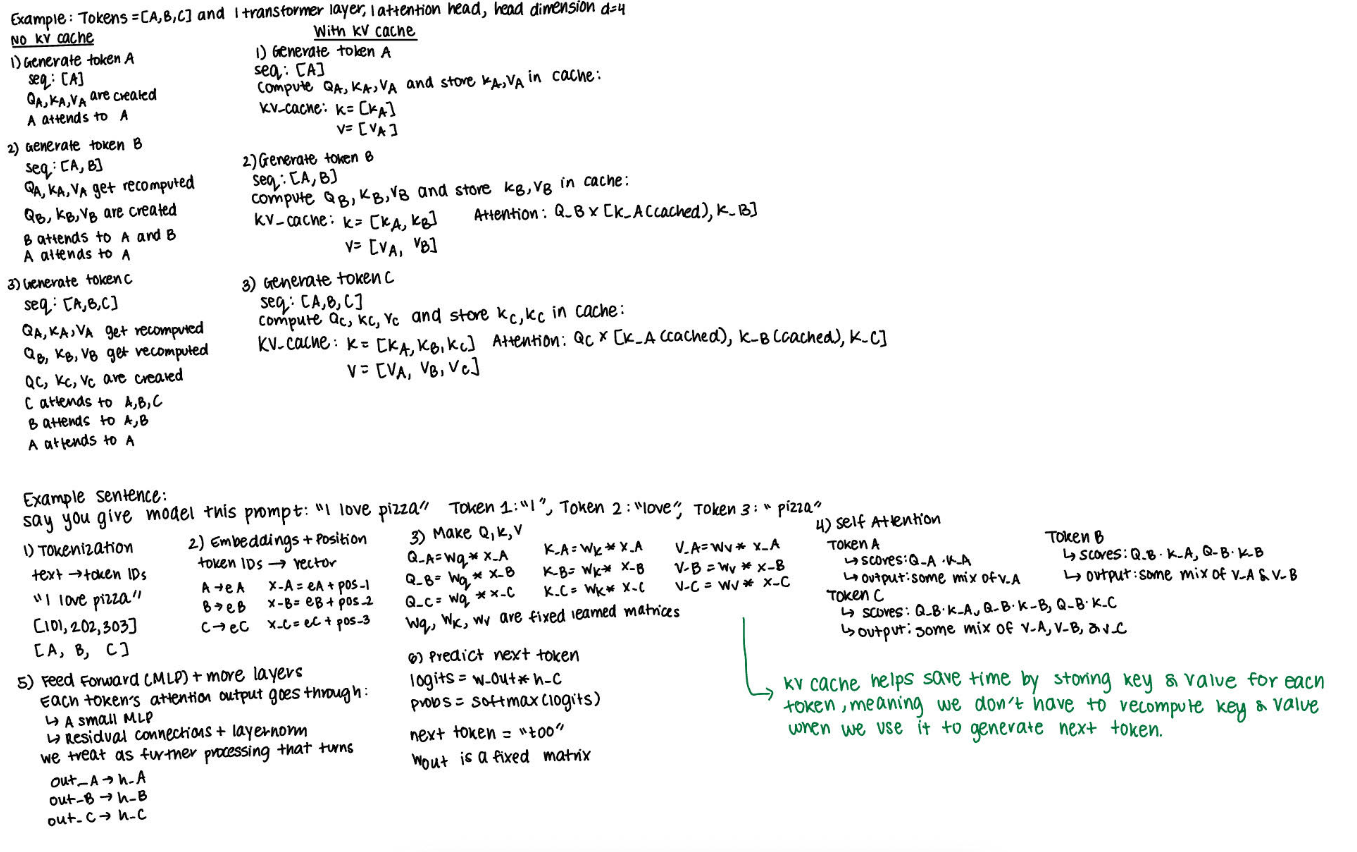

## 1. Setup and Imports

In this section we install and import the libraries we need:

- `transformers` to load a pretrained GPT-2 model
- `torch` for tensor operations and running on GPU
- `time` to measure how long generation takes with and without KV cache



In [1]:
!pip install -q transformers accelerate

import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

## 2. Load a Small GPT-2 Model and Tokenizer

We'll use a small GPT-2 model (`gpt2`) so that:

- It loads quickly
- We can see speed differences clearly even in Colab

The tokenizer converts text → token IDs, and the model maps token IDs → next-token probabilities. We set it to evaluation mode (no training).


In [ ]:
model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

## 3. Define a Prompt and Inspect Tokenization

We'll use a short natural-language prompt to generate from. Here we:

1. Define a text prompt.
2. Tokenize it into input IDs.

In [3]:
prompt = "Transformers use attention to process sequences efficiently."
enc = tokenizer(prompt, return_tensors="pt")
input_ids = enc["input_ids"]

print("Prompt:", prompt)
print("Token IDs:", input_ids[0].tolist())

Prompt: Transformers use attention to process sequences efficiently.
Token IDs: [41762, 364, 779, 3241, 284, 1429, 16311, 18306, 13]


## 4. Naive Decoding (No KV Cache)

In naive autoregressive decoding, at each step we:

1. Feed the entire sequence (prompt + all generated tokens so far) into the model.
2. Ask the model for the next-token logits.
3. Sample or take `argmax` to get the next token.
4. Append that token to the sequence and repeat.

Critically, we **do not use** (KV cache), so the model recomputes attention over all previous tokens at every step. This is simple but inefficient for long sequences.


In [4]:
@torch.no_grad()
def generate_naive(model, input_ids, max_new_tokens=50, temperature=1.0):
    """
    Naive generation: at each step, re-run the entire sequence with use_cache=False.
    """
    generated = input_ids.clone()
    for _ in range(max_new_tokens):
        outputs = model(generated, use_cache=False)
        logits = outputs.logits[:, -1, :]
        if temperature > 0.0:
            probs = torch.softmax(logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        else:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        generated = torch.cat([generated, next_token], dim=-1)
    return generated

## 5. Decoding With KV Cache (Efficient)

Now we implement generation **with** KV caching:

1. First forward pass:
   - Feed the full prompt.
   - Ask the model to return `past_key_values` (the KV cache).
2. For each new token:
   - Feed **only the last token** plus the previous `past_key_values`.
   - The model reuses all past K/V from the cache.
   - It only computes Q/K/V for the new token.
   - It returns updated `past_key_values` which we pass to the next step.

This avoids recomputing attention over the entire history and is much faster for long sequences.


In [5]:
@torch.no_grad()
def generate_with_kv_cache(model, input_ids, max_new_tokens=50, temperature=1.0):
    """
    Efficient generation using KV cache via past_key_values.
    """
    past_key_values = None
    curr_input = input_ids
    generated = input_ids.clone()

    for _ in range(max_new_tokens):
        outputs = model(curr_input, use_cache=True, past_key_values=past_key_values)
        logits = outputs.logits[:, -1, :]
        past_key_values = outputs.past_key_values

        # Sample next token
        if temperature > 0.0:
            probs = torch.softmax(logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        else:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

        generated = torch.cat([generated, next_token], dim=-1)
        curr_input = next_token

    return generated

## 6. Benchmark: Naive vs KV-Cached Decoding

To see the impact of KV caching in practice, we:

- Generate a longer continuation (e.g., 100 tokens).
- Measure wall-clock time for:
  - Naive decoding (no cache)
  - KV-cached decoding
- Compute **tokens per second** for each.

On short sequences the difference may be small, but as the number of generated tokens grows, KV caching should clearly win.


In [6]:
max_new_tokens = 100

# Warm-up
_ = generate_naive(model, input_ids, max_new_tokens=5)
_ = generate_with_kv_cache(model, input_ids, max_new_tokens=5)

# Naive timing
start = time.perf_counter()
out_naive = generate_naive(model, input_ids, max_new_tokens=max_new_tokens)
t_naive = time.perf_counter() - start

# KV cache timing
start = time.perf_counter()
out_cache = generate_with_kv_cache(model, input_ids, max_new_tokens=max_new_tokens)
t_cache = time.perf_counter() - start

print(f"Naive   time: {t_naive:.3f} s for {max_new_tokens} tokens "
      f"→ {max_new_tokens / t_naive:.2f} tokens/sec")
print(f"KV cache time: {t_cache:.3f} s for {max_new_tokens} tokens "
      f"→ {max_new_tokens / t_cache:.2f} tokens/sec")

print("\nNaive sample:\n", tokenizer.decode(out_naive[0]))
print("\nKV cache sample:\n", tokenizer.decode(out_cache[0]))


Naive   time: 50.141 s for 100 tokens → 1.99 tokens/sec
KV cache time: 6.130 s for 100 tokens → 16.31 tokens/sec

Naive sample:
 Transformers use attention to process sequences efficiently. But rather than taking it too far, they conduct a construction, in which the sequence is transformed and processed at a speed that is faster than up-to-date representation when sending different signals. This knowledge makes multiplication and division efficient and minimizes asvendellations.

Using information and techniques implemented in support of runcount processing systems, Zhang became interested in how the digital art process can best handle sequence hierarchies. He developed a framework focused solely on hierarchical processing maximize and minimize credit-

KV cache sample:
 Transformers use attention to process sequences efficiently. They are also mathematically far more knowledgeable about quantitative history than we are of the verbal algorithms they use to generate sequences.

Comparis